In [1]:
# !pip install ohmeow-blurr
# !pip install nlp

In [2]:
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *
import nlp

In [3]:
raw_data = nlp.load_dataset('cnn_dailymail', '3.0.0')
raw_data.keys()

dict_keys(['train', 'validation', 'test'])

In [4]:
df = pd.DataFrame(raw_data['train'])
df.head()

,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years. Under the program, ...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting program, like all GSA practices, is under review .",00027e965c8264c35cc1bc55556db388da82b07f
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. ""I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case,"" Stancheva told CNN in a phone intervie...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .",0002c17436637c4fe1837c935c04de47adb18e9a
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police L

In [5]:
pretrained_model_name = "t5-small"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, model_cls=T5ForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('t5',
 transformers.configuration_t5.T5Config,
 transformers.tokenization_t5.T5Tokenizer,
 transformers.modeling_t5.T5ForConditionalGeneration)

In [6]:
hf_batch_tfm = HF_SummarizationBatchTransform(hf_arch, hf_tokenizer)

blocks = ( 
    HF_TextBlock(hf_arch, hf_tokenizer), 
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm, max_length=150, hf_input_idxs=[0,1])
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSubsetSplitter(0.01, 0.0005))

In [7]:
dls = dblock.dataloaders(df, bs=2)

In [8]:
len(dls.train.items), len(dls.valid.items)

(2871, 143)

In [9]:
dls.train

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 512]), torch.Size([2, 150]))

In [11]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target
0,"A well-known Philadelphia mummer and his daughter have been arrested after allegedly beating and shooting a homeless man in a brutal attack that was caught on surveillance video. Carmen 'Butchie' D'Amato, 62, and Rita D'Amato, 36, were filmed approaching the unnamed man, also 36, in the city's Queen Village neighborhood shortly before 3am on October 25, police said. Shocking footage shows Rita apparently crouching into a batting stance, before striking the victim in the chest with a baseball bat, knocking him to the ground. As he gets up and tries to run, Carmen, who was inducted into the Mummers Hall of Fame aged just 21 and served as captain of the South Philly Vikings, then seemingly fires two shots at his leg. Scroll down for video. Caught on camera: Carmen 'Butchie' D'Amato, 62, and Rita D'Amato, 36, were filmed approaching a homeless man (pictured) in Queen Village, Philadelphia, shortly before 3am on October 25, according to police. Attack: Shocking footage shows Rita apparently crouching into a batting stance, before striking the 36-year-old victim - who has not bee named - in the chest with a baseball bat (pictured), knocking him to the ground. Firing off rounds: As he gets up and tries to run, Carmen, who was inducted into the Mummers Hall of Fame aged just 21, then seemingly fires two shots at his leg. Above, a bright white light shows the gunshot. By the time police arrived at the scene near 2nd and Carpenter Streets, Carmen (left) and Rita (right) had fled. By the time police arrived at the scene near 2nd and Carpenter Streets, the D'Amatos had fled. Officers discovered the homeless man lying on the ground with a broken leg, NBC reported. The victim, who Carmen and Rita reportedly believed may have been breaking into cars, was taken to Thomas Jefferson University Hospital for treatment. He is thought to have since been released. On Friday, warrants were issued for the arrest of Carmen and Rita, who were spotted leaving their house earlier in the day wearing similar clothing to that of the suspects","Carmen 'Butchie' D'Amato, 62, and Rita D'Amato, 36, arrested on Friday. Captured on surveillance camera attacking a homeless man, police said. Footage shows Rita apparently striking victim in chest with baseball bat. As the man tries to run, Carmen then seemingly fires two shots at his leg. Victim was taken to nearby hospital, where he was treated for broken leg. D'Amatos, who reportedly fled scene, charged with aggravated assault. They are due to appear in court on November 16 for preliminary hearing. Carmen is well-known in area; inducted into Mummers"
1,"By. Richard Spillett. Former prison nurse Karen Cosford has been barred from practising after she had an affair with inmate serving a life sentence. A former prison nurse who had an affair with a convicted rapist at a top security jail has been ordered to be struck off the nursing register. Married Karen Cosford had a relationship lasting several months with Brian McBride, who was serving a life sentence at Wakefield Prison, West Yorkshire. She denied any wrongdoing at a trial in 2012 but was found guilty of misconduct by engaging in a sexual relationship with an inmate and was jailed for three years. Cosford, 49, of Normanton, Wakefield, was also found guilty of failing to tell prison authorities that McBride had a mobile phone and bringing in top-ups for the prisoner. Today she was barred from practising as a nurse by medical body, the Nursing and Midwifery Council (NMC), following her release from prison last November. At her trial, Cosford, who worked in the jail's medical centre, claimed McBride, who is serving life for multiple offences of rape and violence, raped her then intimidated her so she would not report it. But jurors at Leeds Crown Court rejected the claim after hearing how she became inappropriately close to McBride, after he duped her into thinking he had wealth on the outside, and started a sexual relationship. The pair had met as 

In [12]:
text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
text_gen_kwargs

{'early_stopping': True,
 'length_penalty': 2.0,
 'max_length': 130,
 'min_length': 30,
 'no_repeat_ngram_size': 3,
 'num_beams': 4,
 'prefix': 'summarize: '}

In [13]:
model = HF_BaseModelWrapper(hf_model)
model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=HF_MaskedLMLoss(),
                cbs=[model_cb],
                splitter=partial(summarization_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

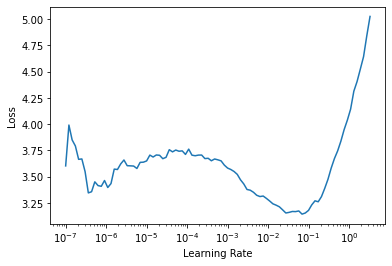

In [14]:
k = learn.lr_find(suggestions=True)

In [15]:
k

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=9.12010818865383e-07)

In [16]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(4.8615, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 149, 32128]))

In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time


In [17]:
learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,2.525264,2.259764,0.388907,0.161089,0.261474,06:32


In [18]:
learn.fit(10, lr_max=3e-5)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,2.154420,2.135232,0.372351,0.153720,0.251954,06:33
1,1.978940,2.160321,0.348378,0.139123,0.237141,06:19
2,1.891379,2.182321,0.337382,0.134775,0.227054,06:16
3,1.844455,2.241297,0.337321,0.132325,0.230616,06:07
4,1.669486,2.266027,0.354064,0.144691,0.240066,06:10
5,1.608713,2.330722,0.349085,0.139748,0.234902,06:09
6,1.550301,2.358022,0.350997,0.139211,0.233425,06:20
7,1.405419,2.402207,0.344998,0.134808,0.229586,06:08
8,1.362793,2.458835,0.329510,0.126885,0.223247,05:58
9,1.273896,2.501071,0.348393,0.133642,0.230698,06:07


In [20]:
learn.show_results(learner=learn, max_n=20)

,text,target,prediction
0,"Former South African president FW de Klerk has sparked outrage after he gave a television interview in which he appeared to justify elements of apartheid. The Nobel Peace Prize laureate, 76, faced widespread condemnation this morning after he told the American news network CNN he believed there was merit in the idea of different ethnic groups living apart. Mr De Klerk told CNN that the idea of ethnic communities being separated, as under apartheid, was 'not repugnant'. FW de Klerk spoke on CNN, saying the idea of separated ethnic communities was not repugnant. He added that black people were not deprived of power under the apartheid regime, saying: 'They were not disenfranchised, they voted' FW de Klerk and Nelson Mandela addressing crowds after Mandela's inauguration in 1994. The former president served as South Africa's last white leader before the advent of democracy in 1994, and served as deputy president under Nelson Mandela until 1996. He was asked by CNN reporter Christiane Amanpour whether he believed apartheid had been morally repugnant. He answered: 'In as much as it trampled human rights it was and remains morally indefensible. 'I have made the most profound apology in front of the Truth Commission and on other occasions about the injustices which were wrought by apartheid.' But he added: 'What I haven't apologised for is the original concept of seeking to bring justice to all South Africans through the concept of nation states. 'In South Africa it failed. By the end of the 70s we had to realise, and accept and admit to ourselves that it had failed. And that is when fundamental reform started.' Mr De Klerk made his remarks as he spoke to CNN in Chicago, where he has been attending a summit of Nobel laureates. The statesman was awarded the peace prize jointly with Nelson Mandela in 1993 after the pair negotiated a peaceful end to apartheid. Mr De Klerk's National Party had previously controlled a white minority government in South Africa from 1948 to 1994. Former South African presidents Nelson Mandela, left, and FW de Klerk, right",FW de Klerk says the idea of apartheid ethnic separation was 'not repugnant' Last white president of South Africa denies that black people were disenfranchised under apartheid regime. He won Nobel Peace Prize with Nelson Mandela in 1993. His comments have provoked anger from South African community.,"FW de Klerk spoke on CNN, saying apartheid was 'morally repugnant' The former South African president served as South Africa's last white leader before the advent of democracy in 1994 . He was awarded the Peace Prize jointly with Nelson Mandela in 1993 ."
1,"(CNN) -- Altovise Davis, the widow of entertainer Sammy Davis Jr., has died. She was 65. Altovise Davis, in a 2008 photo, married Sammy Davis Jr. in 1970. Davis died Saturday at the Cedars-Sinai Medical Center in Los Angeles, California, said her publicist, Amy Malone. She had been admitted two days earlier after suffering a stroke. Davis, a dancer and actress from Brooklyn, New York, met Sammy Davis Jr. on the set of the musical ""Golden Boy"" in London in 1967. The couple married three years later. It was Sammy Davis Jr.'s third marriage. The couple remained together until he died of throat cancer in 1990. The couple had an adopted son. Funeral services will be held in Burbank, California, with the date and time to be announced later. Sammy Davis Jr., himself a musician, was famous for being part of the Rat Pack, which included Frank Sinatra and Dean Martin. CNN's Janet DiGiacomo contributed to this report.","Altovise Davis, 65, died Saturday at a Los Angeles hospital, her publicist says. She had been admitted two days earlier after suffering a stroke. Davis, a dancer and actress, married Sammy Davis Jr. in 1970.","Davis, 65, dies Saturday at Cedars-Sinai Medical Center . Sammy Davis Jr., a dancer and actress from Brooklyn, has died of throat cancer . Davis, in a 2008 photo, married Sammy, Jr. in 1970 ."


In [21]:
test_article = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
"""

In [22]:
outputs = learn.blurr_summarize(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 . Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people . The remaining 456 were largely in aircraft operating on behalf of companies, governments or organisations . All-time deadliest year for aviation was 1972 when 2,429 people were killed in a total of

=== Prediction 2 ===
Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 . Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people . The remaining 456 were largely in aircraft operating on behalf of companies, governments or organisat

In [ ]:
learn.export(fname='ft_cnndm_export.pkl')